In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime, date
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

#Disable warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings('ignore')

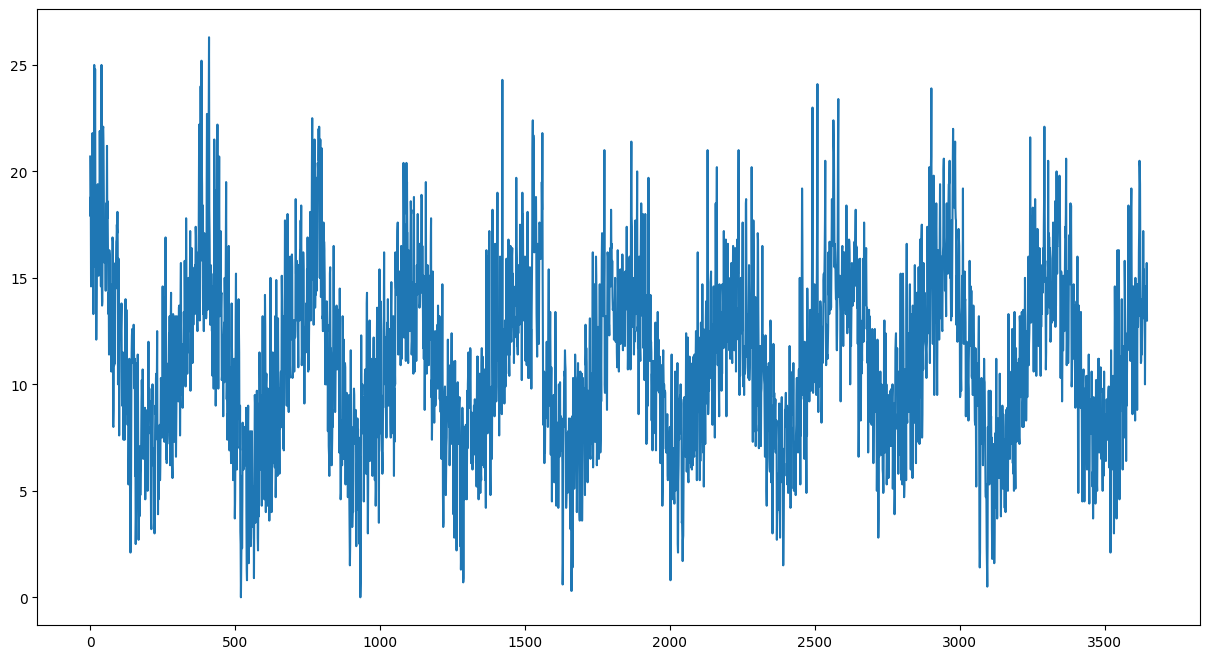

In [2]:
path=r"....\daily-minimum-temperatures-in-me.csv"
df=pd.read_csv(path)
df['Date'] = pd.to_datetime(df.Date, format = '%m/%d/%Y')
df.sort_values(by='Date', inplace=True)
a=[df.loc[i,'Date']-df.loc[i-1,'Date'] for i in range(1,df.shape[0])]
pd.Series(a).value_counts() 

# Let us collect incorrectly assigned (non float) data
b=[]
for i in range(df.shape[0]):
    try:
        float(df.iloc[i,1])
    except ValueError:
        b.append((i,df.iloc[i,1]))

#Rows 565,566 e 1290 have non numeric values. Let us remove them
df.drop([565,566,1290], axis=0, inplace=True)

Y=df.iloc[:,1].astype('float').to_numpy()
X=np.arange(df.shape[0])

plt.figure(figsize=(15,8))
plt.plot(X,Y)
#plt.yticks([])
plt.show()

In [3]:
#We collect here metrics to be used for evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def error(a,b):
    print('Mean abs error: %.2f' % mean_absolute_error(a,b))
    print('Mean squared error: %.2f' % mean_squared_error(a,b))
    print('R2 score: %.2f' % r2_score(a,b))

#As a simple comparison, we look at the performance of the naive strategy 'Tomorrow's temperature is predicted to be equal to today's temperature'. 
#This is the performance our model should definitely beat. 
error(Y[:-1],Y[1:])

Mean abs error: 2.13
Mean squared error: 7.46
R2 score: 0.55


In [4]:
#We create training and testing data 
n_split=int(0.8*Y.shape[0])
time_train=np.arange(0,n_split)
y_train=Y[:n_split]
time_test=np.arange(n_split,Y.shape[0])
y_test=Y[n_split:]

#We also evaluate the naive strategy on the test set
error(y_test[:-1],y_test[1:])

Mean abs error: 1.96
Mean squared error: 6.16
R2 score: 0.63


In [5]:
#We prepare the training data for feeding them to the neural network 
win_size=32
batch_size=256
buffer_size=1000 

def windowed_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

train_data=windowed_dataset(y_train,win_size)

In [6]:
#Our chosen architecture: CONV1D-LSTM-LSTM-DENSE
def create_model():
    model=tf.keras.models.Sequential([
        tf.keras.Input((win_size,1)), # Set the correct input shape for the model
        tf.keras.layers.Conv1D(filters=256,kernel_size=5,padding='causal',activation='relu'), 
        tf.keras.layers.LSTM(40,return_sequences=True),
        tf.keras.layers.LSTM(40), 
        tf.keras.layers.Dense(30,activation='relu'),
        tf.keras.layers.Dense(15,activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model

uncompiled_model=create_model()
uncompiled_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 32, 256)             │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32, 40)              │          47,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 40)                  │          12,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │           1,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │             465 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,727 (248.93 KB)

 Trainable params: 63,727 (248.93 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#Preliminary training session to identify the right value for the learning rate, thanks to the learning rate scheduler
def adjust_learning_rate(dataset):
    model = create_model()  
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.Adam()
    
    model.compile(loss=tf.keras.losses.Huber,
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    return history

lr_history=adjust_learning_rate(train_data)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - loss: 10.5298 - mae: 11.0292 - learning_rate: 1.0000e-05
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 10.5653 - mae: 11.0647 - learning_rate: 1.1220e-05
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 10.5821 - mae: 11.0815 - learning_rate: 1.2589e-05
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 10.4259 - mae: 10.9251 - learning_rate: 1.4125e-05
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 10.4387 - mae: 10.9380 - learning_rate: 1.5849e-05
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 10.3437 - mae: 10.8428 - learning_rate: 1.7783e-05
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 10.3434 - mae: 10.8426 - learning_rate: 1.9953e-05
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 10.1888 - mae: 10.6879 - learning_rate: 2.2387e-05
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 10.1109 - mae: 10.6099 - learning_rate: 2.5

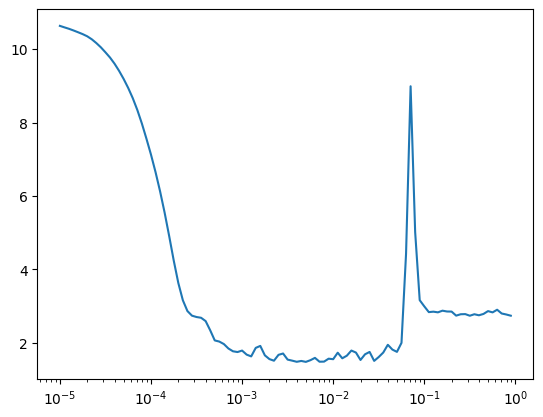

In [10]:
#The plot of the loss on logarithmic scale shows that the best value for the learning rate is between 1e-3 and 2e-3
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])

In [ ]:
#We choose lr=1.5e-3. We find that 150 epochs is enough for the training
tf.keras.backend.clear_session()

#Scelgo lr=1.5*10^-3 
def actual_model():
    model = create_model()
    model.compile(loss=tf.keras.losses.Huber,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-3),
                  metrics=["mae"])  
    return model

model=actual_model()
history=model.fit(train_data, epochs=150)

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))

#We plot the loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.legend(loc=0)
plt.show()

#We plot the loss excluding the first 10 epochs to check the model keeps learning until the end
plt.plot(epochs[10:], loss[10:], 'r', label='Training loss')
plt.legend(loc=0)
plt.show()

In [ ]:
#We prepare the test set for forecasting. We use win_size data points to predict the following value of the sequence
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

prediction=model_forecast(model, Y[n_split-win_size:-1], win_size).squeeze()

In [ ]:
#We plot the test set and the prediction for comparison.
plt.figure(figsize=(15,8))
plt.plot(time_test,y_test, label='real')
plt.plot(time_test,prediction, label='predicted')
#plt.yticks([])
plt.legend()
plt.show()

In [ ]:
#We test the model
error(y_test,prediction)

'''Training the model I found (to be compared with the naive strategy):
MAE: 1.75
MSE: 4.91
r2: 0.71
'''